In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

class WandBWrapper:
    def __init__(self, prefix=''):
        import wandb
        self.api = wandb.Api()
        self.prefix = prefix
    
    def get_runs(self, name):
        return self.api.runs(f"{self.prefix}{name}")
    
    def _preprocess_config(self, run):
        return {
            k: v for k,v in run.config.items()
            if not k.startswith('_')
        }
    
    def sort_valid_columns(self, cols):
        priority = {
            'matthews_correlation': 0,
            'f1': 1,
            'f1_a':1,
            'accuracy': 2,
            'exact_match': 3,
            'pearson': 5,
            'spearmanr': 6
        }
        
        for col in cols:  # mnli dirty fix
            if 'matched_accuracy' in col:
                return ['valid_mean']
            
        cols = [col for col in cols if 'f1_m' not in col]
        
        stripper = lambda x: x[x.find('_') + 1:]
        return list(sorted(cols, key=lambda x: priority[stripper(x)]))
    
    def _best_in_history(self, run, key):
        history = run.history()
        all_valid_columns = [col for col in history.columns if 'valid' in col and 'mean' not in col]
        best_row_idx = history[key].astype('float').fillna(0).argmax()
        all_valid_columns = self.sort_valid_columns(all_valid_columns)
        return [max(history[key][best_row_idx], 0) for key in all_valid_columns]
    
    def get_full_history(self, runs, tasks, model_size=''):
        task_names = [model_size + '_' + task_name for task_name in tasks]
        return {
            task_name: pd.DataFrame({
                run.name: run.history()['valid_mean']
                for run in self.get_runs(task_name)
                if run.name in runs
            })[runs]
            for task_name in task_names
        }
    
    def get_runs_best(self, name, run_name_filter=None):
        runs = self.get_runs(name)
        return {
            run.name: self._best_in_history(run, 'valid_mean')
            for run in runs
            if run_name_filter is None or run.name in run_name_filter
        }
    
    def get_runs_tasks_df(self, runs, tasks, model_size=''):
        task_names = [model_size + '_' + task_name for task_name in tasks]
        results = {task_name: self.get_runs_best(task_name, runs) for task_name in task_names}
        return pd.DataFrame(results).T[runs].T

# Latex Table

In [2]:
tasks = [
    # 'glue-wnli',
    # 'glue-rte',
    'glue-qqp',  # new datasets
    'glue-qnli', # new datasets
    'glue-mnli', # new datasets
    'glue-sst2', # new datasets
    'glue-stsb', # new datasets
    'glue-mrpc',
    'glue-cola',
    'superglue-multirc', # new datasets
    'superglue-rte',
    'superglue-cb',
    'superglue-copa',
    'superglue-wic',
    'superglue-boolq',
]

runs = [
    '10_simple_dropout',
    '10_simple',
    '10_residual_128_dropout',
    '10_residual_128',
    '10_combine_128_dropout',
    '10_combine_128',
    'full'
]

base_df =  WandBWrapper("mohalisad/hzi_cluster_t5_").get_runs_tasks_df(runs=runs, tasks=tasks, model_size='base')
small_df = WandBWrapper("mohalisad/hzi_cluster_t5_").get_runs_tasks_df(runs=runs, tasks=tasks, model_size='small')
base_df['base_superglue-cb']['10_combine_128'] = [0.7826, 0.8214]

In [3]:
tasks = [
    'glue-stsb',
    'glue-mrpc',
    'glue-cola',
    'superglue-multirc',
    'superglue-rte',
    'superglue-cb',
    'superglue-copa',
    'superglue-wic',
    'superglue-boolq',
]

runs = [
    '10_attempt',
    '10_attempt_dropout',
]

base_attempt_df =  WandBWrapper("iclr_attempt_lmt5_t5_").get_runs_tasks_df(runs=runs, tasks=tasks, model_size='base')
small_attempt_df =  WandBWrapper("iclr_attempt_lmt5_t5_").get_runs_tasks_df(runs=runs, tasks=tasks, model_size='small')

In [4]:
order = [
    '10_simple_dropout',
    '10_simple',
    '10_attempt_dropout',
    '10_attempt',
    '10_residual_128_dropout',
    '10_residual_128',
    '10_combine_128_dropout',
    '10_combine_128',
    'full'
]
base_merge = pd.concat([base_df, base_attempt_df]).loc[order].fillna('-')
small_merge = pd.concat([small_df, small_attempt_df]).loc[order].fillna('-')

In [5]:
import numpy as np
import itertools

def _tblr_args(rows_count_seq):
    top_rows = list(np.cumsum([4, *rows_count_seq]))
    top_rows_str = ', '.join(map(str, top_rows[:-1]))
    full_split = ', '.join(map(lambda x: str(x-1), top_rows[1:]))
    bold_line = ', '.join(map(str, top_rows))
    return r"""column{2-16} = {c},
    cell{1}{2} = {r=3}{b},
    cell{1}{3} = {c=7}{c},
    cell{1}{10} = {c=6}{},
    vline{2, 3,10,16} = {1-3}{},
    hline{2} = {3-15}{},
    row{%s} = {c},
    cell{%s}{1} = {c=16}{},
    hline{%s} = {-}{},
    hline{%s} = {-}{2px},,"""  % (top_rows_str, top_rows_str, full_split, bold_line)

def _head_rows():
    return [
        r" & \rot{\eztb{Dropout}} & GLUE &&&&&&& SuperGLUE &&&&&&",
        r"Task→ && QQP & QNLI & MNLI & SST-2 & STS-B & MRPC & CoLA & MultiRC & RTE & CB & COPA & WiC & BoolQ & Avg.",
        r"Method↓ && F1/Acc. & Acc. & Acc. & Acc. & PCC/$\rho$ & F1/Acc. & MCC & F1a/EM & Acc. & F1/Acc. & Acc. & Acc. & Acc. & -"
    ]

def _section_row(name):
    return name + "&&&&&& &&&&&&&&&"

def to_pure_number(item):
    if isinstance(item, list):
        item = [float(x) for x in item if x != '-']
        if len(item) == 0:
            return '-'
        return sum(item) / len(item)
    return item

def to_pure_numbers(numbers):
    return np.array([
        to_pure_number(list_item)
        for list_item in numbers
    ])

def _convert_single_number(single_number):
    if single_number == '-':
        return '-'
    if isinstance(single_number, str):
        single_number = float(single_number)
    return f"{100 * single_number:.1f}"

def _convert_number(n):
    if not isinstance(n, list):
        n = [n]
    number_str = "/".join([_convert_single_number(n_item) for n_item in n])
    if to_pure_number(n) == 0:
        return f'{number_str} $\\dag$'
    return number_str

def _normal_row(name, is_dropout, numbers, bold_mask=None):
    numbers_str = [_convert_number(n) for n in numbers]
    if bold_mask is not None:
        for idx, bold_state in enumerate(bold_mask):
            if bold_state:
                numbers_str[idx] = "\\textbf{" + numbers_str[idx] + "}"
                
    mark = "\\cmark" if is_dropout else "\\xmark"
    return " & ".join([name, mark, *numbers_str])

def _compute_mean(numbers):
    return np.array([[
        '-'
        if '-' in list(row)
        else to_pure_numbers(row).mean()
        for row in numbers
    ]]).T

def pefts_besk_masks_gen(numbers):
    numbers = np.stack([
        np.array([
            0. if x == '-' else float(x)
            for x in to_pure_numbers(row)
        ])
        for row in numbers
    ])
    best = numbers.max(axis=0, keepdims=True)
    return numbers == best

def generate_rows(names, dropouts, numbers):
    mean = _compute_mean(numbers)
    
    numbers = np.concatenate((numbers, mean), axis=1)
    
    pefts = numbers[:-1, :]
    full = numbers[-1, :]

    pefts_best_masks = pefts_besk_masks_gen(pefts)
    rows = [
        _normal_row(*args)
        for args in zip(names, dropouts, pefts, pefts_best_masks)
    ]
    rows.append(_normal_row("Full Fine-tuning", True, full))
    return rows
    
def generate_table(input_dict):
    all_rows = [(_section_row(key), *val) for (key, val) in input_dict.items()]
    rows_count_seq = [len(row) for row in all_rows]
    all_rows_flatten = itertools.chain.from_iterable(all_rows)
    end_line = '\\\\\n'
    rows = [
        *_head_rows(),
        *all_rows_flatten
    ]
    return r"""\begin{tblr}{
    %s
}
%s
\end{tblr}
""" % (_tblr_args(rows_count_seq), end_line.join(rows + [""]))

In [6]:
dropouts = [True, False] * 4
names = ['Simple PT'] * 2 + ['ATTEMPT'] * 2 + ['Residual PT'] * 2 + ['SuperPos PT'] * 2
base_rows = generate_rows(names, dropouts, base_merge.to_numpy())
small_rows = generate_rows(names, dropouts, small_merge.to_numpy())
print(generate_table({
    'T5v1.1 Small LM-Adapted': small_rows,
    'T5v1.1 Base LM-Adapted': base_rows
}))

\begin{tblr}{
    column{2-16} = {c},
    cell{1}{2} = {r=3}{b},
    cell{1}{3} = {c=7}{c},
    cell{1}{10} = {c=6}{},
    vline{2, 3,10,16} = {1-3}{},
    hline{2} = {3-15}{},
    row{4, 14} = {c},
    cell{4, 14}{1} = {c=16}{},
    hline{13, 23} = {-}{},
    hline{4, 14, 24} = {-}{2px},,
}
 & \rot{\eztb{Dropout}} & GLUE &&&&&&& SuperGLUE &&&&&&\\
Task→ && QQP & QNLI & MNLI & SST-2 & STS-B & MRPC & CoLA & MultiRC & RTE & CB & COPA & WiC & BoolQ & Avg.\\
Method↓ && F1/Acc. & Acc. & Acc. & Acc. & PCC/$\rho$ & F1/Acc. & MCC & F1a/EM & Acc. & F1/Acc. & Acc. & Acc. & Acc. & -\\
T5v1.1 Small LM-Adapted&&&&&& &&&&&&&&&\\
Simple PT & \cmark & 58.2/65.5 & 50.6 & 33.2 & 79.4 & 9.8/7.9 & 81.2/68.4 & 0.0 $\dag$ & 17.3/0.3 & 52.3 & 0.0/0.0 $\dag$ & 0.0 $\dag$ & 50.6 & 62.2 & 37.1\\
Simple PT & \xmark & 70.8/75.3 & 72.8 & 50.7 & 84.9 & 0.0/0.0 $\dag$ & 82.5/71.3 & 0.0 $\dag$ & 22.6/0.6 & 49.1 & 0.0/0.0 $\dag$ & 0.0 $\dag$ & 57.4 & 62.6 & 41.5\\
ATTEMPT & \cmark & - & - & - & - & 0.0/0.0 $\dag$ & 0.

# Sample Size Compare

In [1]:
wandb = WandBWrapper("mohalisad/hzi_cluster_comp_run_t5_")

tasks = {
    'glue-mrpc': ('MRPC', 'F1/Acc.'),
    'glue-cola': ('CoLA', 'MCC'),
    'superglue-rte': ('RTE', 'Acc.'),
    'superglue-cb': ('CB', 'F1/Acc.'),
    'superglue-copa': ('COPA', 'Acc.'),
    'superglue-wic': ('WiC', 'Acc.'),
    'superglue-boolq': ('BoolQ', 'Acc.')
}

runs = [
    '10_combine_4',
    '10_combine_8',
    '10_combine_16',
    '10_combine_32',
    '10_combine_64',
    '10_combine_128',
    '10_combine_256'
]

comp_df = wandb.get_runs_tasks_df(runs=runs, tasks=tasks.keys(), model_size='base')

NameError: name 'WandBWrapper' is not defined

NameError: name 'comp_df' is not defined

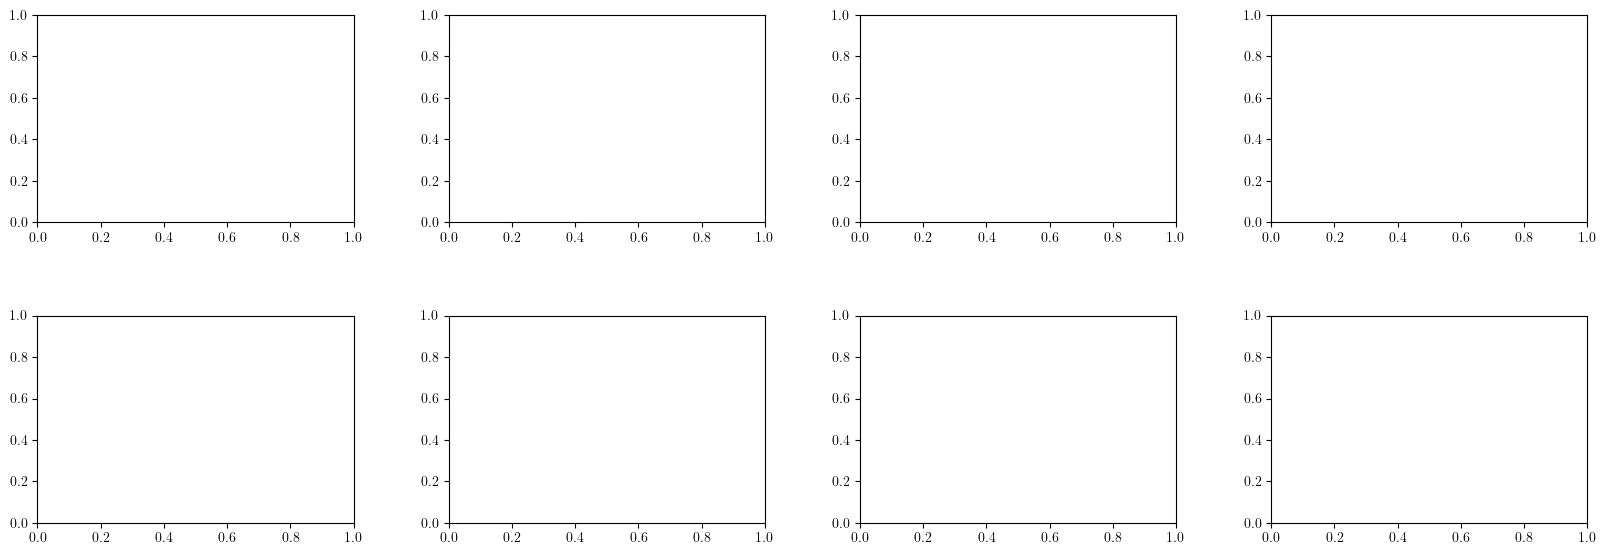

In [2]:


rows = [4, 8, 16, 32, 64, 128, 256]

plt.rcParams.update({"text.usetex": True, "font.family": "Times New Roman"})

fig, ax = plt.subplots(2, 4, figsize=(20, 6.6))
plt.subplots_adjust(hspace=0.45, wspace=0.3)

data_rows = comp_df.T.to_numpy()
data_rows = np.concatenate((data_rows, data_rows.mean(axis=0, keepdims=True)))
task_names = [*tasks.values(), ('Avg.', 'Average')]

for idx, ((task_name, score_metric), data) in enumerate(zip(task_names, data_rows)):
    ax[idx // 4, idx % 4].plot(range(len(rows)), data, 'g-s', linewidth=2, markersize=9)
    ax[idx // 4, idx % 4].set_title(task_name, fontsize=25)
    ax[idx // 4, idx % 4].tick_params(labelsize=16)
    ax[idx // 4, idx % 4].set_xticks(ticks=range(len(rows)))
    ax[idx // 4, idx % 4].set_xticklabels(labels=rows)
    ax[idx // 4, idx % 4].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax[idx // 4, idx % 4].set_xlabel('Number of sampled tokens $(m)$', fontsize=16)
    ax[idx // 4, idx % 4].set_ylabel(f'{score_metric} on validation', fontsize=16)


# Learning Performance

In [31]:
wandb = WandBWrapper("mohalisad/hzi_cluster_t5_")

tasks = {
    'glue-mrpc': ('MRPC', 'Mean(F1,Acc)'),
    'glue-cola': ('CoLA', 'MCC'),
    'superglue-rte': ('RTE', 'Acc.'),
    'superglue-cb': ('CB', 'Mean(F1,Acc)'),
    'superglue-copa': ('COPA', 'Acc.'),
    'superglue-wic': ('WiC', 'Acc.'),
    'superglue-boolq': ('BoolQ', 'Acc.')
}

runs = {
    # '10_combine_128_dropout': 'SuperposPrompts w/ dropout',
    '10_combine_128': 'SuperPos-Prompt w/o dropout',
    '10_residual_128': 'Residual Prompt w/o dropout',
    '10_simple': 'Simple Prompt w/o dropout'
}

runs_attempt = {
    '10_attempt': 'ATTEMPT w/o dropout'
}

full_history = WandBWrapper("mohalisad/hzi_cluster_t5_").get_full_history(runs=runs.keys(), tasks=tasks.keys(), model_size='base')
attempt_history = WandBWrapper("mohalisad/iclr_attempt_lmt5_t5_").get_full_history(runs=runs_attempt.keys(), tasks=tasks.keys(), model_size='base')

In [35]:
another_run = [run.history()['valid_mean'] for run in WandBWrapper("mohalisad/hzi_cluster_comp_run_t5_base_").get_runs("superglue-cb") if run.name == '10_combine_128'][0]
full_history['base_superglue-cb']['10_combine_128'] = another_run

for key in full_history.keys():
    full_history[key]['10_attempt'] = attempt_history[key]['10_attempt']

In [36]:
list(zip(tasks.values(), full_history.keys()))

[(('MRPC', 'Mean(F1,Acc)'), 'base_glue-mrpc'),
 (('CoLA', 'MCC'), 'base_glue-cola'),
 (('RTE', 'Acc.'), 'base_superglue-rte'),
 (('CB', 'Mean(F1,Acc)'), 'base_superglue-cb'),
 (('COPA', 'Acc.'), 'base_superglue-copa'),
 (('WiC', 'Acc.'), 'base_superglue-wic'),
 (('BoolQ', 'Acc.'), 'base_superglue-boolq')]

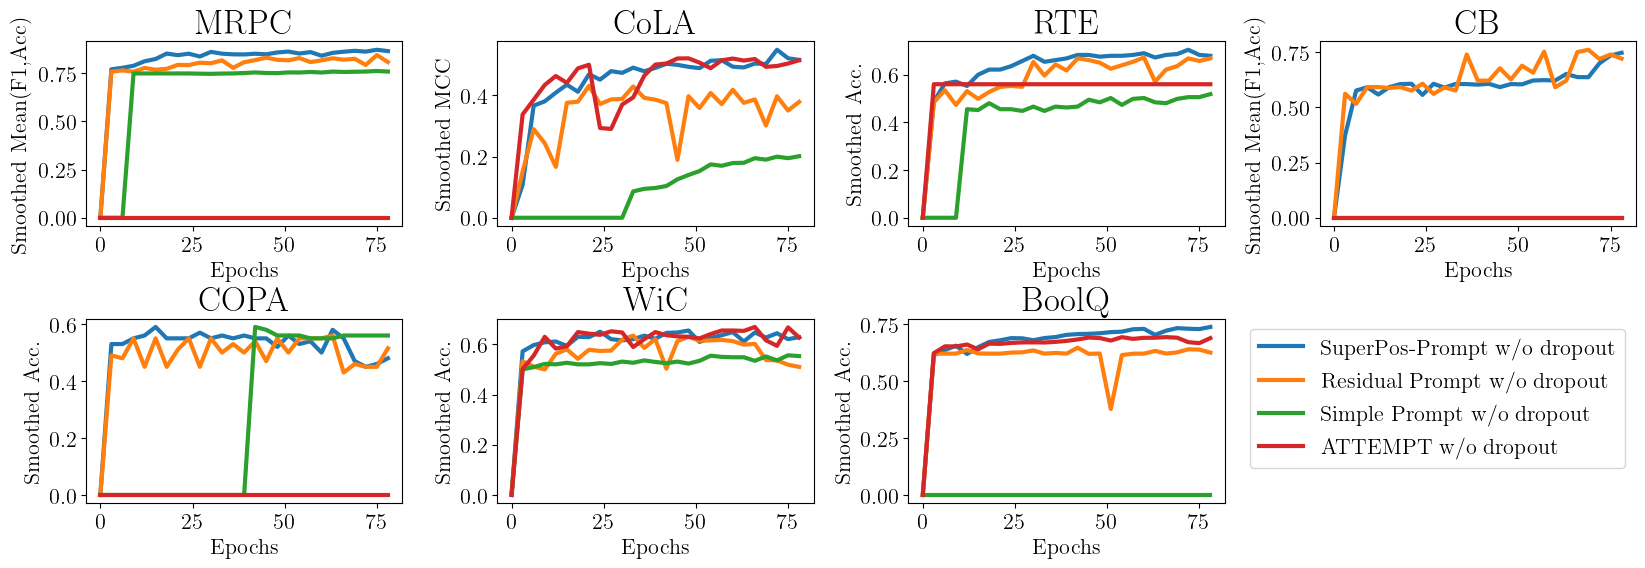

In [37]:
def moving_average(row, step):
    return_value = [
        np.median(row[start:start+step]) for start in range(0, len(row), step)
    ]
    return_value[0] = 0
    return return_value

step = 3

fig, ax = plt.subplots(2, 4, figsize=(20, 6))
fig.delaxes(ax[1, 3])
plt.subplots_adjust(hspace=0.5, wspace=0.3)

for idx, ((plot_title, score_metric), plot_data) in enumerate(zip(tasks.values(), full_history.values())):
    mat = np.maximum(plot_data.T.to_numpy(), 0)
    epochs = range(0, mat.shape[1], step)
    
    selected_ax = ax[idx // 4, idx % 4]
    
    for run_name, history in zip((runs | runs_attempt).values(), mat):
        selected_ax.plot(epochs, moving_average(history, step=step), label=run_name, linewidth=3)

    selected_ax.set_title(plot_title, fontsize=25)
    selected_ax.set_xlabel('Epochs', fontsize=16)
    selected_ax.set_ylabel(f'Smoothed {score_metric}', fontsize=16)
    selected_ax.tick_params(labelsize=16)
    # ax[idx].legend(fontsize=20)

    
handles, labels = selected_ax.get_legend_handles_labels()
leg = fig.legend(handles, labels, loc='lower right', fontsize=16, ncols=1, bbox_to_anchor=(0.9, 0.15))
# _plot(full_history['base_superglue-wic'], runs.values(), step=3)

In [27]:
wandb = WandBWrapper("mohalisad/hzi_cluster_t5_")

tasks = {
    'glue-mrpc': ('MRPC', 'Mean(F1,Acc)'),
    'glue-cola': ('CoLA', 'MCC'),
    'superglue-rte': ('RTE', 'Acc.'),
    'superglue-cb': ('CB', 'Mean(F1,Acc)'),
    'superglue-copa': ('COPA', 'Acc.'),
    'superglue-wic': ('WiC', 'Acc.'),
    'superglue-boolq': ('BoolQ', 'Acc.')
}

runs = {
    '10_combine_128': 'SuperPos-Prompt w/o dropout',
    '10_combine_128_dropout': 'SuperPos-Prompt w/ dropout'
}

full_history = wandb.get_full_history(runs=runs.keys(), tasks=tasks.keys(), model_size='base')

In [28]:
another_run = [run.history()['valid_mean'] for run in WandBWrapper("mohalisad/hzi_cluster_comp_run_t5_base_").get_runs("superglue-cb") if run.name == '10_combine_128'][0]
full_history['base_superglue-cb']['10_combine_128'] = another_run

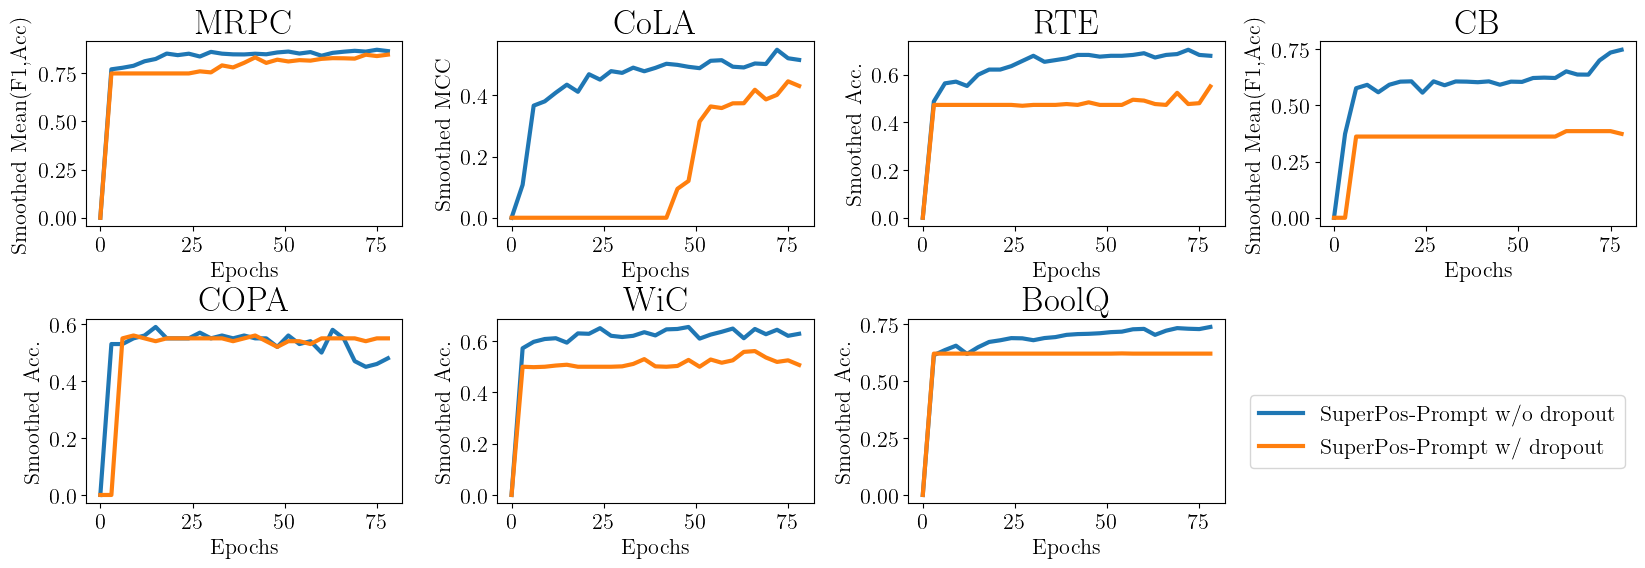

In [29]:
fig, ax = plt.subplots(2, 4, figsize=(20, 6))
fig.delaxes(ax[1, 3])
plt.subplots_adjust(hspace=0.5, wspace=0.3)

for idx, ((plot_title, score_metric), plot_data) in enumerate(zip(tasks.values(), full_history.values())):
    mat = np.maximum(plot_data.T.to_numpy(), 0)
    epochs = range(0, mat.shape[1], step)
    
    selected_ax = ax[idx // 4, idx % 4]
    
    for run_name, history in zip(runs.values(), mat):
        selected_ax.plot(epochs, moving_average(history, step=step), label=run_name, linewidth=3)

    selected_ax.set_title(plot_title, fontsize=25)
    selected_ax.set_xlabel('Epochs', fontsize=16)
    selected_ax.set_ylabel(f'Smoothed {score_metric}', fontsize=16)
    selected_ax.tick_params(labelsize=16)
    # ax[idx].legend(fontsize=20)

    
handles, labels = selected_ax.get_legend_handles_labels()
leg = fig.legend(handles, labels, loc='lower right', fontsize=16, ncols=1, bbox_to_anchor=(0.9, 0.15))
# _plot(full_history['base_superglue-wic'], runs.values(), step=3)

In [4]:
wandb = WandBWrapper("mohalisad/iclr_resp_t5_")

tasks = [
    'glue-mrpc',
    'glue-cola',
    'superglue-rte',
    'superglue-cb',
    'superglue-copa',
    'superglue-wic',
    # 'superglue-boolq'
]

runs = [
    '10_combine_128_dropout',
    '10_combine_128',
]    

# base_df = wandb.get_runs_tasks_df(runs=runs, tasks=tasks, model_size='base')
small_df = wandb.get_runs_tasks_df(runs=runs, tasks=tasks, model_size='small')

In [5]:
small_df

small_glue-mrpc  small_glue-cola  small_superglue-rte  \
10_combine_128_dropout         0.862417         0.260256             0.566787   
10_combine_128                 0.869824         0.407415             0.675090   

                        small_superglue-cb  small_superglue-copa  \
10_combine_128_dropout            0.430474                  0.58   
10_combine_128                    0.769246                  0.57   

                        small_superglue-wic  
10_combine_128_dropout             0.615987  
10_combine_128                     0.664577

In [ ]:
87.9 38.9 64.6 75.2 58.0 65.7 68.9 65.6